In [1]:
from typing import Callable
import os

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import optax
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices

# Set random seed
seed = 23
set_random_seed(seed)

# causal libraries
import cdt, castle

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

# %% [markdown]
# ## Load the actual connectome data

# %%
# load the weighted adjacency matrices for ER and connectome

# Specify the folder where the adjacency matrices were saved
folder = '../data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# Change name of the connectome adjacency matrix to C and C_dag
C = G_A_init_t_ordered_adj_matrix
C_dag = G_A_init_t_ordered_dag_adj_matrix

# Now ensure that both DAG adjacency matrices are binary, if they aren't already
ER_dag_bin = (ER_dag != 0).astype(int)
C_dag_bin = (C_dag != 0).astype(int)

ER_true = ER_dag_bin
C_true = C_dag_bin

# %% [markdown]
# ## Create data to debug and implement the pcax version of NOTEARS

# %%
# actual data
#B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# debugging data
#B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


#B_true = C_dag_bin # if you want to use the connectome-based DAG # best performance so far with 200,000 samples: 0.06 
#B_true = ER_dag_bin # if you want to use the ER-based DAG

#B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
#B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
#B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
#B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# create equivalent ER4 and ER6 graphs
#B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
#B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# create equivalent SF4 and SF6 graphs
#B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
#B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
#B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6


# create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
#B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800
W_true = simulate_parameter(B_true)

# sample data from the linear SEM
# actual data
#X = simulate_linear_sem(W_true, n=25000, sem_type='gauss')
# for debugging
X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# now standardized data, where each variable is normalized to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# NOTE: you may not write positional arguments after keyword arguments. 
# That is, the values that you are passing positionally have to come first!

# create a dataset using the simulated data
# NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# we should expect to use that many samples actually to be able to learn the graph in a comparable way.
#dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
#true_dag, X = dataset.B, dataset.X

# %%
print(np.sum(B_true))

# %%
import pcax.utils as pxu
print(dir(pxu))

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Adjacency matrix loaded from ../data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ../data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ../data/ER_adj_matrix.npy
Adjacency matrix loaded from ../data/ER_dag_adj_matrix.npy
20.0
['Mask', 'Optim', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_mask', '_misc', '_optim', '_serialisation', 'load_params', 'm', 'save_params', 'step']


Detecting CUDA device(s) : [0]


In [2]:
# v1: single vode
# %%
# v1: single vode
class Complete_Graph(pxc.EnergyModule):
    def __init__(
        self, 
        input_dim: int, 
        n_nodes: int, 
        hidden_dim: int = 3, 
        act_fn: Callable[[jax.Array], jax.Array] = jax.nn.relu,
        has_bias: bool = False
    ) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)
        self.n_nodes = px.static(n_nodes)
        self.hidden_dim = px.static(hidden_dim)
        self.has_bias = has_bias
        self.act_fn = px.static(act_fn)

        # Initialize MLPs for each connection (n_nodes x n_nodes matrix of MLPs)
        self.mlp_layers = []
        # Initialize vodes only for hidden layers of MLPs
        self.mlp_vodes = []
        
        for i in range(n_nodes):
            node_layers = []
            node_vodes = []
            for j in range(n_nodes):
                # Create MLP: input_dim -> hidden_dim -> input_dim
                mlp = [
                    pxnn.Linear(input_dim, hidden_dim, bias=has_bias),
                    pxnn.Linear(hidden_dim, input_dim, bias=has_bias)
                ]
                # Create vode only for hidden layer
                vode = pxc.Vode((hidden_dim,))
                node_layers.append(mlp)
                node_vodes.append(vode)

            self.mlp_layers.append(node_layers)
            self.mlp_vodes.append(node_vodes)

        # Initialize adjacency matrix as a LayerParam
        init_weights = jnp.ones((n_nodes, n_nodes))
        init_weights = jax.numpy.fill_diagonal(init_weights, 0.0, inplace=False)
        self.adj_weights = pxnn.LayerParam(init_weights)

        # Initialize main node vode
        self.vodes = [pxc.Vode((n_nodes, input_dim))]
        #self.vodes = [pxc.Vode((n_nodes, ))]

    def freeze_nodes(self, freeze=True):
        # Only freeze the main node vode
        self.vodes[0].h.frozen = freeze

    def are_vodes_frozen(self):
        return self.vodes[0].h.frozen
    
    def get_W(self):
        """Returns the weighted adjacency matrix."""
        return self.adj_weights.get()

    #def mlp_forward(self, x, i, j):
    #    """Forward pass through MLP for connection i->j with nonlinear activation."""
    #
    #    # print shape of x inside mlp_forward
    #    print(f"The shape of x inside mlp_forward: {x.shape}")
    #
    #    # print value of self.hidden_dim then print self.hidden_dim.get()
    #    #print(f"This is self.hidden_dim: {self.hidden_dim}") # wrong because it is a px.static object
    #    print(f"The is self.hidden_dim.get(): {self.hidden_dim.get()}") # correct
    #    
    #    if i == j:  # Skip self-loops but initialize Vode cache
    #        # Create a dummy input for the Vode module to initialize the cache
    #        dummy_input = jnp.zeros((self.hidden_dim.get(),))
    #        out = self.mlp_vodes[i][j](dummy_input)
    #        return out
    #
    #    # print the shape of x
    #    print(f"The shape of x in mlp_forward: {x.shape}")
    #
    #    # First linear layer
    #    h = self.mlp_layers[i][j][0](x)
    #    # Apply activation and vode on hidden layer (vode not frozen)
    #    h = self.act_fn(h)
    #    h = self.mlp_vodes[i][j](h)
    #    
    #    # Final linear layer (no vode on output)
    #    out = self.mlp_layers[i][j][1](h)
    #    
    #    return out

    def mlp_forward(self, x, i, j):
        """Forward pass through MLP for connection i->j with nonlinear activation."""
        if i == j:  # Skip self-loops but initialize Vode cache
            # Create a dummy input for the Vode module to initialize the cache
            dummy_input = jnp.zeros((self.hidden_dim.get(),))  # Use hidden_dim instead of input_dim
            # Ensure hidden_dim.get() returns a concrete integer. If not, hardcode the value.
            # For example, if hidden_dim is 3:
            # dummy_input = jnp.zeros((3,))
            self.mlp_vodes[i][j](dummy_input)
            return 0.0

        # First linear layer
        h = self.mlp_layers[i][j][0](x)
        # Apply nonlinear activation
        h = self.act_fn(h)
        # Pass through the Vode module
        h = self.mlp_vodes[i][j](h)

        # Final linear layer
        out = self.mlp_layers[i][j][1](h)

        return out


    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        
        if x is not None:

            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, input_dim)            
            

            # print the shape of x
            print(f"The shape of x in __call__ if statement: {x.shape}")
            # print the shape of reshaped_x
            print(f"The shape of reshaped_x in __call__ if statement: {reshaped_x.shape}")


            for j in range(n_nodes):
                for i in range(n_nodes):
                        mlp_out = self.mlp_forward(reshaped_x[i], i, j)      

            # print successfully finished mlp_forward in __call__ for x is not None
            print("Successfully finished mlp_forward in __call__ for x is not None")

            self.vodes[0](reshaped_x)

        else:
            # Get current node values
            x_ = self.vodes[0].get('h')

            reshaped_x_ = x_.reshape(n_nodes, input_dim)
            
            # print the shape of x_
            print(f"The shape of x_ in __call__ else statement: {x_.shape}")
            # print the shape of reshaped_x_
            print(f"The shape of reshaped_x_ in __call__ else statement: {reshaped_x_.shape}")

            # Compute weighted sum of MLP outputs for each node
            outputs = []
            for j in range(n_nodes):
                node_output = 0
                for i in range(n_nodes):
                    # Apply MLP and weight by adjacency matrix entry
                    mlp_out = self.mlp_forward(x_[i], i, j)
                    node_output += self.adj_weights.get()[i, j] * mlp_out
                outputs.append(node_output)
            
            # Stack outputs and update vodes
            output = jnp.stack(outputs)
            self.vodes[0](output)

            # run the forward pass for each node to have VodeParam values that are not None
            #for j in range(n_nodes):
            #    for i in range(n_nodes):
            #            mlp_out = self.mlp_forward(x_[i], i, j)

        return self.vodes[0].get('h')


In [3]:

# Usage
input_dim = 1
n_nodes = X.shape[1]
#model = Complete_Graph(input_dim, n_nodes, has_bias=False)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, act_fn=jax.nn.leaky_relu)

# Get weighted adjacency matrix
W = model.get_W()
print(W)
print()
print(W.shape)
print(model)


# Freezing all nodes
model.freeze_nodes(freeze=True)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

# Unfreezing all nodes
model.freeze_nodes(freeze=False)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

# %%
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-2 # Notes: 5e-1 is too high
h_learning_rate = 1e-2
T = 64

nm_epochs = 2000
batch_size = 128

lam_h = 1e1 # 2e2 -> 5e2 # this move works well! FIRST MOVE
lam_l1 = 1e-3 # 1e-2 -> 3e-2 # this move works well! SECOND MOVE

# %%
# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    print("Forward: Starting")
    result = model(x)
    print("Forward: Completed")
    return result

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), out_axes=(None, 0), axis_name="batch")
def energy(*, model: Complete_Graph):
    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    d = model.n_nodes.get()
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    energy = model.energy()
    print(f"Energy: PC energy term: {energy}")

    # L1 regularization using adjacency matrix
    l1_reg = jnp.sum(jnp.abs(W))
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint
    h_reg = jnp.trace(jax.scipy.linalg.expm(jnp.multiply(W, W))) - d
    print(f"Energy: DAG constraint term: {h_reg}")
    
    # Combined loss
    obj = jax.lax.pmean(energy, axis_name="batch") + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    return obj, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")    

    # reinitialise the optimiser state between different batches (NOTE: this is just educational and not needed here because the SGD we use is not-stateful due to lack of momentum)
    print("6. Reinitialising the optimiser state")
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))
    print("7. Optimiser state reinitialised")

    print(f"8. Doing {T} inference steps!")
    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            _, g = pxf.value_and_grad(pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]), has_aux=True)(energy)(model=model)
            optim_h.step(model, g["model"], True)

    # print that T inference steps have been done
    print("9. Done with T inference steps!")
        
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("10. Before computing gradients")
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
        print("7. After computing gradients")
        print("Gradient structure:", g)

        print("11. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].adj_weights.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        g["model"].adj_weights.set(weight_grads)
        print("12. After zeroing out the diagonal gradients")

        
    print("13. Before optimizer step")
    #optim_w.step(model, g["model"])
    optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("14. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("15. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("16. After final forward")

    model.freeze_nodes(freeze=False)
    print("17. Nodes unfrozen")

    return e_avg_per_sample

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    e_avg_per_sample_energies = []
    for batch in dl:

        e_avg_per_sample = train_on_batch(T, batch, model=model, optim_w=optim_w, optim_h=optim_h)
        e_avg_per_sample_energies.append(e_avg_per_sample)

    W = model.get_W()

    # compute epoch energy
    epoch_energy = jnp.mean(jnp.array(e_avg_per_sample_energies))
    return W, epoch_energy

# %%
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est


def ensure_DAG(W):
    """
    Ensure that the weighted adjacency matrix corresponds to a DAG.

    Inputs:
        W: numpy.ndarray - a weighted adjacency matrix representing a directed graph

    Outputs:
        W: numpy.ndarray - a weighted adjacency matrix without cycles (DAG)
    """
    # Convert the adjacency matrix to a directed graph
    g = nx.DiGraph(W)

    # Make a copy of the graph to modify
    gg = g.copy()

    # Remove cycles by removing edges
    while not nx.is_directed_acyclic_graph(gg):
        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for node, in_degree in nx.in_degree_centrality(h).items():
                if in_degree == 0:
                    h.remove_node(node)
                    finished = False

            for node, out_degree in nx.out_degree_centrality(h).items():
                if out_degree == 0:
                    h.remove_node(node)
                    finished = False

            if finished:
                break

        # Find a cycle with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # Extract the cycle path and adjust it to start at the first occurrence of the repeated node
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Find edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Randomly pick an edge to remove
        edge = edges[np.random.choice(len(edges))]
        gg.remove_edge(*edge)

    # Convert the modified graph back to a weighted adjacency matrix
    W_acyclic = nx.to_numpy_array(gg)

    return W_acyclic

# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes
W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)
# Create the custom dataset with standardized data
dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    #optim_w = pxu.Optim(optax.sgd(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.Mask(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(optax.adafactor(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, weight_decay=5e-2), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, nesterov=True), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, nesterov=False), pxu.Mask(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(optax.adam(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))


[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]

(10, 10)
(Complete_Graph):
  .has_bias: True
  .mlp_layers[0][0][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][0][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][0][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][0][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][1][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][1][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][1][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][1][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][2][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][2][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][2][1].nn.weight:

In [4]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
energies = []

# Calculate the initial MAE, SID, and SHD
MAE_init = MAE(W_true, model.get_W())
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, compute_binary_adjacency(model.get_W()))
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(model.get_W()))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_energy = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Calculate the metrics and store them
        W = np.array(W)
        MAEs.append(float(MAE(W_true, W)))
        SHDs.append(float(SHD(B_true, compute_binary_adjacency(W))))
        energies.append(float(epoch_energy))
        
        # Update progress bar with the current status
        pbar.set_description(f"MAE {MAEs[-1]:.4f}, SHD {SHDs[-1]:.4f} || Energy {energies[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))

# %%
print(model)
print()
with pxu.step(model, clear_params=pxc.VodeParam.Cache):
    _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
    print(g["model"])


Start difference (cont.) between W_true and W_init: 0.9835
Start SHD between B_true and B_init: 70.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/2000 [00:00<?, ?it/s]os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
Forward: Starting
The shape of x in __call__ if statement: (10,)
The shape of reshaped_x in __call__ if statement: (10, 1)
Successfully finished mlp_forward in __call__ for x is not None
Forward: Completed
5. After forward for initialization
6. Reinitialising the optimiser state
7. Optimiser state reinitialised
8. Doing 64 inference steps!
Energy: Starting computation
The shape of x_ in __call__ else statement: (10, 1)
The shape of reshaped_x_ in __call__ else statement: (10, 1)
Energy: Got model output
Energy: Got W (shape: (10, 10)) and d: 10
Energy: PC energy term: Traced<ShapedArray(float32[])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[128])>with<JVPTrace(level=3/0)> with
    primal = Traced<ShapedArray(float32[128])>with<DynamicJaxprTrace(level=1/0)>
    tangent = Traced<ShapedArray(float32[128])>with<JaxprTrace(level=2/0)> with
      pval = (ShapedArr

MAE 0.3001, SHD 21.0000 || Energy 11.0809: 100%|██████████| 2000/2000 [16:38<00:00,  2.00it/s]         


An epoch (with compiling and testing) took on average: 0.4991 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Complete_Graph):
  .has_bias: True
  .mlp_layers[0][0][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][0][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][0][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][0][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][1][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][1][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][1][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][1][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][2][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][2][0].nn.bias: LayerParam([3], float32)
  .mlp_layers[0][2][1].nn.weight: LayerParam([1,3], float32)
  .mlp_layers[0][2][1].nn.bias: LayerParam([1], float32)
  .mlp_layers[0][3][0].nn.weight: LayerParam([3,1], float32)
  .mlp_layers[0][3][0].nn.bias: LayerParam([3], float32)
  .mlp

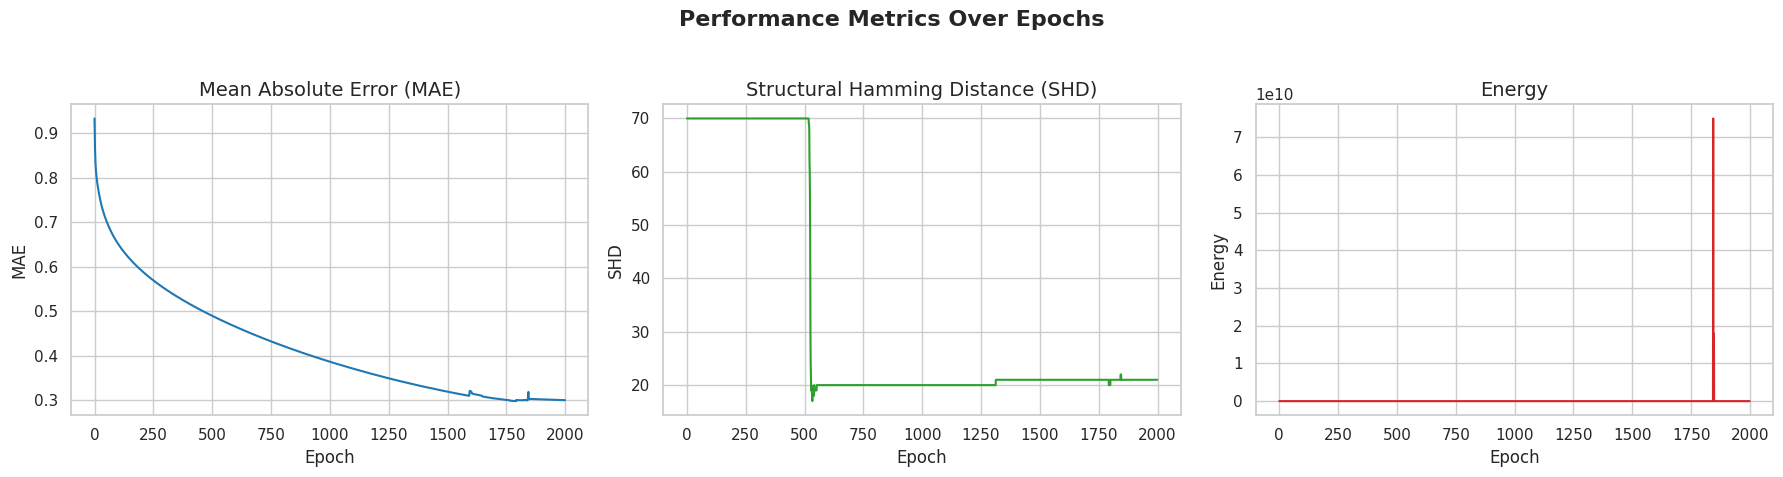

In [5]:

# %%
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

# Create a figure and axis with a 1x3 layout for side-by-side plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(len(MAEs)), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(len(energies)), y=energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()


False
Is the estimated binary adjacency matrix a DAG? True
The h_reg term for the true weighted adjacency matrix W_true is: 0.0000
The h_reg term for the estimated weighted adjacency matrix W_est is: 0.0005
The h_reg term for the fixed weighted adjacency matrix W_fix is: 0.0000
The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      0.0247 -0.0474 -0.0001  0.    ]
 [-0.0564  0.      0.084   0.007   0.0105]
 [-0.1555  0.0128  0.      0.1414  0.    ]
 [ 0.0921  0.2172 -0.0456  0.      0.1426]
 [-0.2134 -0.0001  0.0266  0.0066  0.    ]]


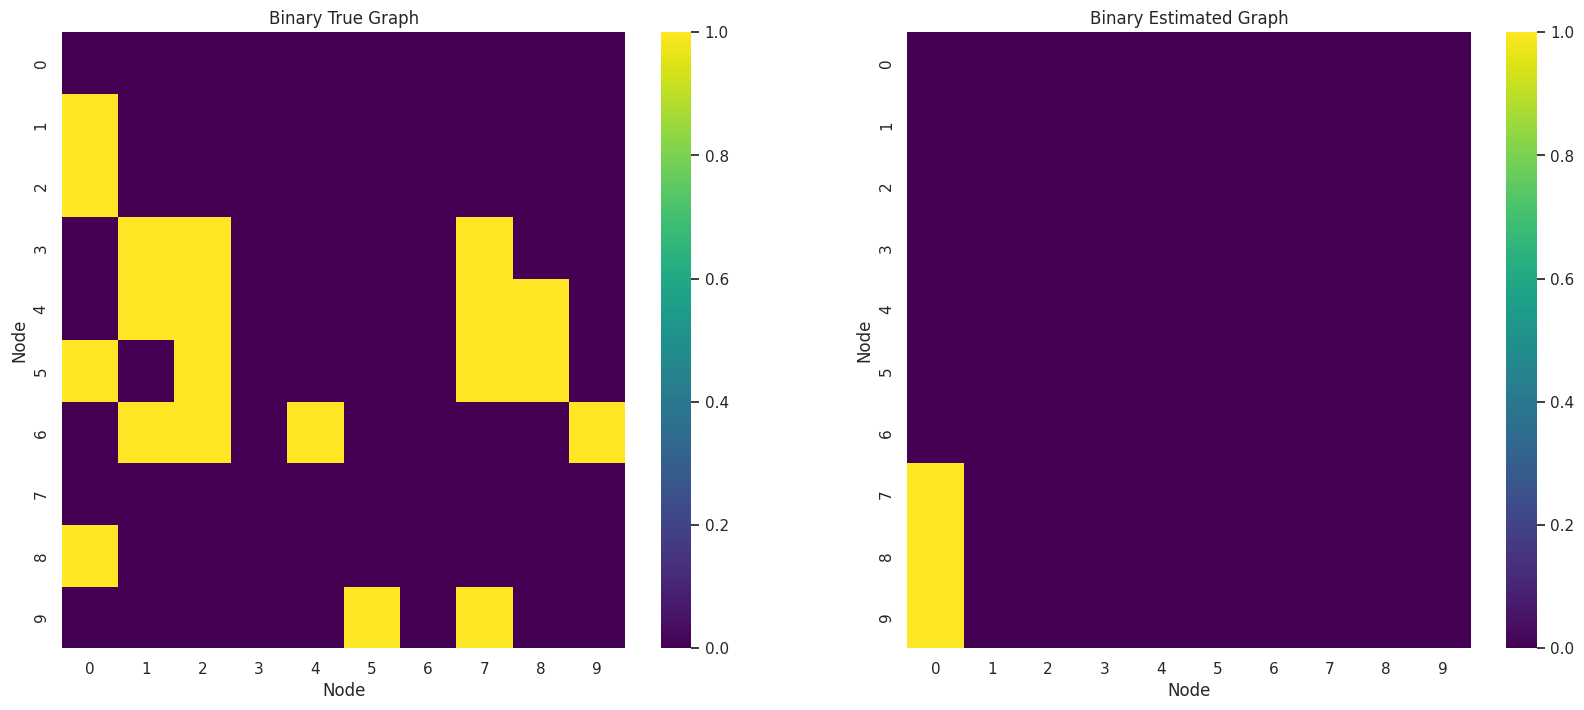

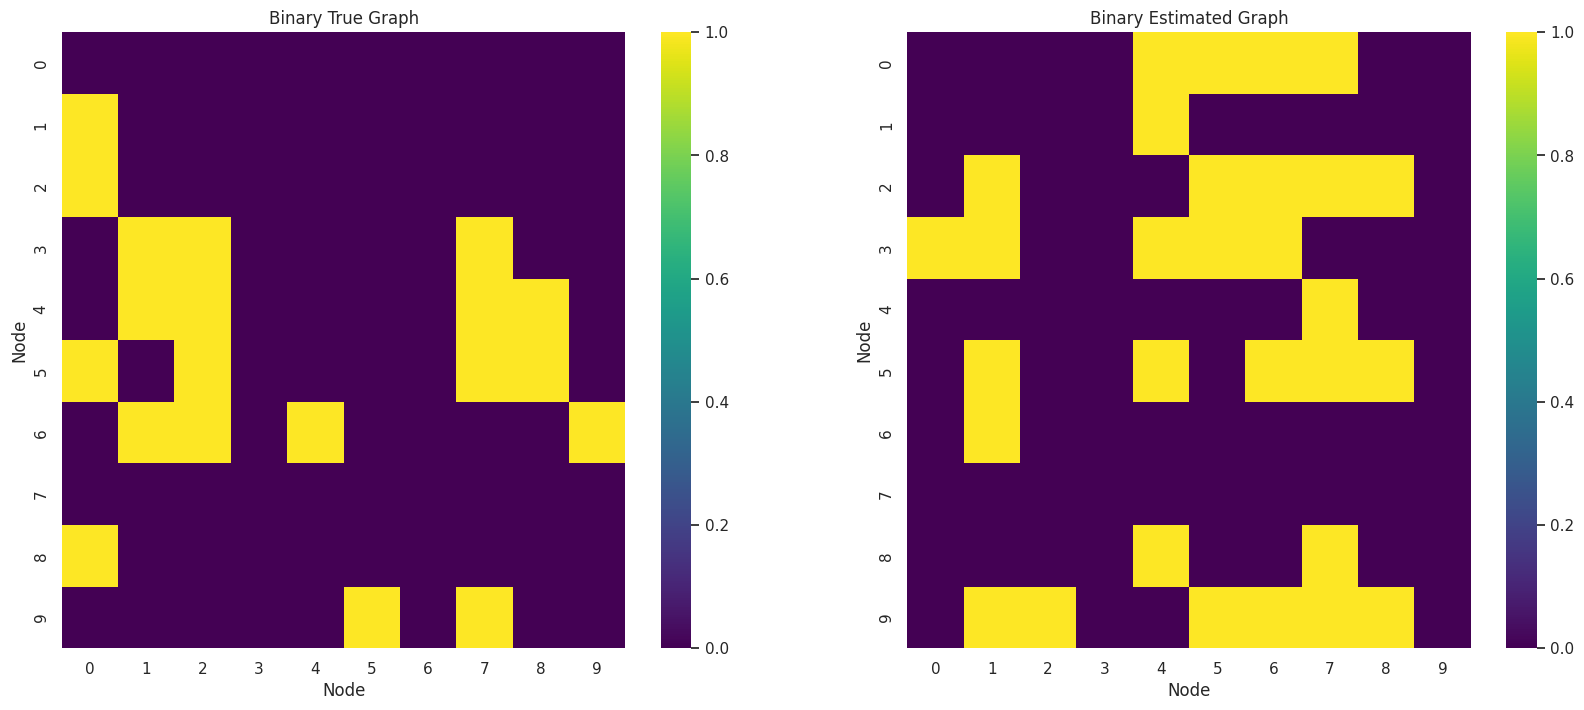

3
30.0
20.0


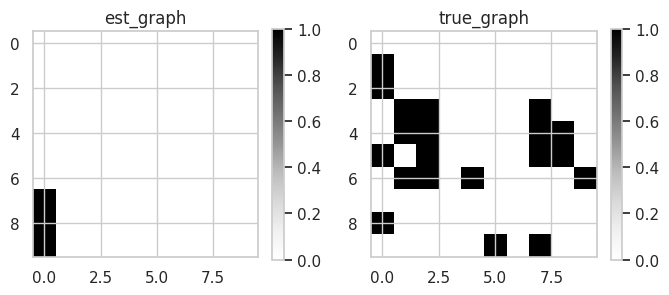

{'fdr': 0.6667, 'tpr': 0.05, 'fpr': 0.08, 'shd': 21, 'nnz': 3, 'precision': 0.3333, 'recall': 0.05, 'F1': 0.087, 'gscore': 0.0}
{'fdr': 0.7667, 'tpr': 0.35, 'fpr': 0.92, 'shd': 30, 'nnz': 30, 'precision': 0.2333, 'recall': 0.35, 'F1': 0.28, 'gscore': 0.0}


In [6]:

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

W_fix = ensure_DAG(W_est)
B_fix = 1.0*(W_fix != 0)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Example usage:
adj_matrix = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
])

print(is_dag(adj_matrix))  # Output: False, since the graph has a cycle.

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")

# Define fucntion to compute h_reg based W with h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d, here * denotes the hadamard product
def compute_h_reg(W):
    """This function computes the h_reg term based on the matrix W."""
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - W.shape[0]
    return h_reg

# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the true weighted adjacency matrix W_true is: {h_reg_true:.4f}")
# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the estimated weighted adjacency matrix W_est is: {h_reg_est:.4f}")
h_reg_fix = compute_h_reg(W_fix)
print(f"The h_reg term for the fixed weighted adjacency matrix W_fix is: {h_reg_fix:.4f}")

# We note that B_est is a DAG even though h_reg is not equal to 0.0 (but only close to 0.0). 
# This is because the matrix exponential is not a perfect measure of the DAG constraint, but it is a good approximation.

# %%
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# %%
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_fix)

# %%
print(np.sum(B_est))
print(np.sum(B_fix))
print(np.sum(B_true))

# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

met_pcax_fix = MetricsDAG(B_fix, B_true)
print(met_pcax_fix.metrics)


